<a href="https://colab.research.google.com/github/Anonymoussub460/a-RNA/blob/main/A_RNA_Adversarial_Radio_Noise_Attack_to_Fool_Radar_based_Environment_Perception_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.fft as fft
import random
#from scipy.fft import fft, fftfreq



# 1.  Prepare dataset & Implement the model




In [4]:
import scipy.io
data = scipy.io.loadmat('Data.mat') 
label = scipy.io.loadmat('Lab.mat') 
X = data.get('Data')
Y = label.get('Lab')

In [5]:
import numpy as np
indices = np.random.permutation(X.shape[0])
training_idx, test_idx = indices[:800], indices[800:]
training_data, test_data = X[training_idx,:], X[test_idx,:]
training_label, test_label = Y[training_idx], Y[test_idx]

In [6]:
n_features = 1
X_train_np = training_data.reshape((training_data.shape[0], n_features, training_data.shape[1]))
X_test_np = test_data.reshape((test_data.shape[0], n_features, test_data.shape[1]))
y_train_np = training_label
y_test_np = test_label

In [7]:
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_train_ts = torch.Tensor(X_train_np)
X_test_ts = torch.Tensor(X_test_np)
y_train_ts = torch.Tensor(y_train_np-1).type(torch.LongTensor).view(-1)
y_test_ts = torch.Tensor(y_test_np-1).type(torch.LongTensor).view(-1)

train_dataset = TensorDataset(X_train_ts,y_train_ts) 
train_dataloader = DataLoader(train_dataset, batch_size = 4) 
test_dataset = TensorDataset(X_test_ts,y_test_ts)
test_dataloader = DataLoader(test_dataset, batch_size = 4)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1,16, 3)  
        self.conv2 = nn.Conv1d(16,32, 3)
        self.conv3 = nn.Conv1d(32,64, 3)
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        self.fc1 = nn.Linear(5120, 16)
        self.fc2 = nn.Linear(16, 5)
    def forward(self,x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = F.max_pool1d(x,2)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = F.max_pool1d(x,2)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = F.max_pool1d(x,2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.leaky_relu(x) 
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)  
        return output

In [9]:
model = Net()
model.load_state_dict(torch.load('./1dcnn_uwb_net.pth'))  #_adv_trained
model.eval()

Net(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (leaky_relu): LeakyReLU(negative_slope=0.01, inplace=True)
  (fc1): Linear(in_features=5120, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=5, bias=True)
)



*   Test the model



In [10]:
test_dataloader_ = DataLoader(test_dataset, batch_size = 1)
correct = 0
for data, target in test_dataloader_:  
    output = model(data ) 
    pred = output.argmax(dim=1, keepdim=True) 
    #print(pred) 
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nAccuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_dataloader.dataset),
    100. * correct / len(test_dataloader.dataset)))


Accuracy: 292/294 (99%)



* Shifting functions:

In [11]:
##---------------- circular shifting ---------------##

def fill_after(k, noise, lengths, reminder):
    nb_of_patches = reminder//lengths
    rest = np.mod(reminder, lengths)
    a = []
    if nb_of_patches != 0:
        if rest != 0:
            for i in range(nb_of_patches):
                a = np.concatenate((a, noise), axis=None)
            for i in range(rest):
                a = np.concatenate((a, noise[i]), axis=None)
        else:
            for i in range(nb_of_patches):
                a = np.concatenate((a, noise), axis=None)
    else:
        for i in range(nb_of_patches):
            a = np.concatenate((a, noise), axis=None)
        if rest !=0:
            for i in range(rest):
                a = np.concatenate((a, noise[i]), axis=None)
        #else:
            
    return rest, a

def fill_before(k, noise, lengths, maxlen):
    
    rest, a = fill_after(k, noise, lengths, maxlen - k )
    reminder_first = k//(lengths-rest)   
    b = []
    if reminder_first != 0:
        if k < (lengths - rest):
            b = np.concatenate((b, noise[rest:k]), axis=None)
        else:
            b = np.concatenate((b, noise[rest:lengths]), axis=None)
            
            _ , d = fill_after(k, noise, lengths, k - (lengths - rest) )
            
            b = np.concatenate((b, d), axis=None)
    
    else:
        if k != 0 and (lengths - rest) == k:
            b = np.concatenate((b, noise[k]), axis=None)
        elif k != 0 and (lengths - rest) != k:
            if rest != 0:
                if k <= rest: 
                    b = np.concatenate((b, noise[lengths-rest:k+lengths-rest]), axis=None)
                else:
                    b = np.concatenate((b, noise[lengths-rest:lengths]), axis=None)
                    b = np.concatenate((b, noise[0 :k-rest]), axis=None)

            else:
                b = np.concatenate((b, noise[rest:k+rest]), axis=None)

    c = np.concatenate((b, a), axis=None)

    return c

In [37]:
def mask(input, lengths, maxlen, k):  
    #a = np.ones(lengths)
    m = maxlen - (k + len(input))
    mask = np.pad(input, (k, m), 'constant', constant_values=(0, 0))
    return mask.reshape(1,1,maxlen)

# 2. Test baseline attacks

* FGSM attack

In [13]:
def fgsm(model,  x, y, eps) :  
    
    loss = nn.CrossEntropyLoss()
    x.requires_grad = True
            
    outputs = model(x)
    pred = outputs.data.max(1, keepdim=True)[1][0].item()
    cost = loss(outputs, y) 
    cost.backward()
    model.zero_grad()  
    attack_signal = x + eps*x.grad.sign() 
    attack_signal = torch.clamp(attack_signal, x.min(), x.max())
    
    return attack_signal.detach()

* PGD attack

In [14]:
def pgd(model, x, y, loss_fn, num_steps, step_size, step_norm, eps, eps_norm, y_target=None):
    x_org = x
    x_adv = x.clone().detach().requires_grad_(True).to(x.device)
    targeted = y_target is not None
    num_channels = x.shape[1] 

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)

        prediction = model(_x_adv)
        #pred = prediction.data.max(1, keepdim=True)[1][0].item()
        #print(i, pred)

        loss = loss_fn(prediction, y_target if targeted else y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm

            gradients = step_size * _x_adv.grad.sign() #* torch.from_numpy(mask(input, lengths, maxlen, k))
            #print(gradients.shape)
            if targeted:
                # Targeted: Gradient descent with on the loss of the (incorrect) target label
                # w.r.t. the image data
                x_adv -= gradients
            else:
                # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                # the model parameters
                x_adv += gradients

        # Project back into l_norm ball and correct range
        
        if eps_norm == 'inf':
            # Workaround as PyTorch doesn't have elementwise clip
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps) 

        else:
            delta = x_adv - x

            x_adv = x + delta

    return x_adv.detach()

* UAP 

In [15]:
from typing import TYPE_CHECKING, Callable, List, Optional, Tuple, Union
def projection(values: np.ndarray, eps: Union[int, float, np.ndarray], norm_p: Union[int, float, str]) -> np.ndarray:

    # Pick a small scalar to avoid division by 0
    tol = 10e-8
    values_tmp = values.reshape((values.shape[0], -1))

    if norm_p == 2:
        if isinstance(eps, np.ndarray):
            raise NotImplementedError("The parameter `eps` of type `np.ndarray` is not supported to use with norm 2.")

        values_tmp = values_tmp * np.expand_dims(
            np.minimum(1.0, eps / (np.linalg.norm(values_tmp, axis=1) + tol)), axis=1
        )

    elif norm_p == 1:
        if isinstance(eps, np.ndarray):
            raise NotImplementedError("The parameter `eps` of type `np.ndarray` is not supported to use with norm 1.")

        values_tmp = values_tmp * np.expand_dims(
            np.minimum(1.0, eps / (np.linalg.norm(values_tmp, axis=1, ord=1) + tol)),
            axis=1,
        )

    elif norm_p in [np.inf, "inf"]:
        if isinstance(eps, np.ndarray):
            eps = eps * np.ones_like(values)
            eps = eps.reshape([eps.shape[0], -1])

        values_tmp = np.sign(values_tmp) * np.minimum(abs(values_tmp), eps)

    else:
        raise NotImplementedError(
            'Values of `norm_p` different from 1, 2, `np.inf` and "inf" are currently not ' "supported."
        )

    values = values_tmp.reshape(values.shape)

    return values



In [16]:
j = 0
test_dataloader_ = DataLoader(test_dataset, batch_size = 296)
for data, target in test_dataloader_:
    x_test, y_test = data, target
# one hot encode
y_encoded = list()
for value in y_test:
	letter = [0 for _ in range(5)]
	letter[value] = 1
	y_encoded.append(letter)
#print(y_encoded)
y = torch.from_numpy(np.array(y_encoded))
h = 280
images = torch.zeros((h,1,660))
for i in range(h):
  images[i] = x_test[i]
labels = torch.zeros((h,5))
for i in range(h):
  labels[i] = y[i]

In [17]:
def UAP(x, labels, max_iter, eps, num_steps, step_size, norm, eps_norm, step_norm, loss_fn):
    # Init universal perturbation
    y_index = np.argmax(labels, axis=1) #
    nb_instances = len(x)
    noise = torch.zeros(x.shape[2]) #torch.zeros(1,1,lengths)
    # Generate the adversarial examples
    nb_iter = 0
    threshold = 0.3

    while nb_iter < max_iter:
        # Go through all the examples randomly
        rnd_idx = random.sample(range(nb_instances), nb_instances)
        print(nb_iter)

        # Go through the data set and compute the perturbation increments sequentially
        for j, ex in enumerate(x[rnd_idx]):
            x_i = ex[None, ...]
            #select random position k

            current_label = model(x_i + noise).argmax(dim=1, keepdim=True)
            original_label = y_index[rnd_idx][j]

            if current_label == original_label:
                # Compute adversarial perturbation
                adv_xi = pgd(model, x_i + noise, labels[rnd_idx][[j]], loss_fn , num_steps, step_size, step_norm, eps_norm, eps, y_target=None)  # = torch.tensor(eps)

                new_label = model(adv_xi.float()).argmax(dim=1, keepdim=True) 

                # If the class has changed, update v
                if current_label != new_label:
                    noise = adv_xi.detach() - x_i.detach()
                    noise = projection(noise, eps, norm).float()

        nb_iter += 1
    return noise

* Test under synchronized setting

In [96]:
test_dataloader = DataLoader(test_dataset, batch_size = 1)
for data, target in test_dataloader:
    data, target = data, target
correct = 0

eps = 0.01   
step_size = 0.005 
num_steps = 20  
norm = np.inf
eps_norm='inf' 
step_norm='inf'
loss_fn = nn.CrossEntropyLoss()

for data, target in test_dataloader:
    #adv_noise = fgsm(model, data, target, eps = 0.001)
    adv_noise = pgd(model, data, target, loss_fn =loss_fn, num_steps = num_steps, step_size = step_size, step_norm = step_norm, eps_norm = eps_norm, eps = torch.tensor(eps))
    output = model(data + adv_noise) 
    pred = output.argmax(dim=1, keepdim=True) 
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nAdv Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_dataloader.dataset),
    100 - 100. * correct / len(test_dataloader.dataset)))


Adv Accuracy: 6/294 (98%)



In [158]:
test_dataloader = DataLoader(test_dataset, batch_size = 1)
for data, target in test_dataloader:
    data, target = data, target
correct = 0

adv_noise_uap = UAP(images, labels, max_iter = 20, eps = 0.02, num_steps = 20, step_size = 0.01, norm = np.inf, eps_norm='inf', step_norm='inf', loss_fn = nn.CrossEntropyLoss())

for data, target in test_dataloader:
    output = model(data + adv_noise_uap) 
    pred = output.argmax(dim=1, keepdim=True) 
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nAdv Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_dataloader.dataset),
    100 - 100. * correct / len(test_dataloader.dataset)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19

Adv Accuracy: 85/294 (71%)



* Test under desynchronized setting

In [97]:
test_dataloader = DataLoader(test_dataset, batch_size = 1)
for data, target in test_dataloader:
    data, target = data, target
correct = 0
eps = 0.01   
step_size = 0.005 
num_steps = 20  
norm = np.inf
eps_norm='inf' 
step_norm='inf'
loss_fn = nn.CrossEntropyLoss()

maxlen = data.shape[2]
lengths = data.shape[2]
for data, target in test_dataloader:
    k = np.random.randint(0, maxlen)
    #adv_noise = torch.from_numpy(fill_before(k, adv_noise_uap.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()  #circular shift
    adv_noise_pgd = pgd(model, data, target, loss_fn =loss_fn, num_steps = num_steps, step_size = step_size, step_norm = step_norm, eps_norm = eps_norm, eps = torch.tensor(eps))
    adv_noise = torch.from_numpy(fill_before(k, adv_noise_pgd.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()  #circular shift
    output = model(data + adv_noise) 
    pred = output.argmax(dim=1, keepdim=True) 
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nAdv Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_dataloader.dataset),
    100 - 100. * correct / len(test_dataloader.dataset)))


Adv Accuracy: 98/294 (67%)



# 3. Shift resistant patch (SRP)

In [67]:
def srp(images, labels, max_iter, eps, num_steps, step_size, norm, eps_norm, step_norm, loss_fn, lengths, maxlen):
    # Init universal perturbation
    x = images #
    y_index = np.argmax(labels, axis=1) #
    nb_instances = len(x)
    noise = torch.zeros((lengths)) #torch.zeros(1,1,lengths)
    # Generate the adversarial examples
    nb_iter = 0

    while nb_iter < max_iter:
        # Go through all the examples randomly
        rnd_idx = random.sample(range(nb_instances), nb_instances)
        print(nb_iter)

        # Go through the data set and compute the perturbation increments sequentially
        for j, ex in enumerate(x[rnd_idx]):
            x_i = ex[None, ...]
            #select random position k
            k = np.random.randint(0, maxlen)  # -lengths

            current_label = model(x_i +  torch.from_numpy(fill_before(k, noise.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()).argmax(dim=1, keepdim=True)
            original_label = y_index[rnd_idx][j]

            if current_label == original_label:
                # Compute adversarial perturbation
                adv_xi = pgd(model, (x_i +   torch.from_numpy(fill_before(k, noise.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()), labels[rnd_idx][[j]],
                            loss_fn =loss_fn, num_steps = num_steps, step_size = step_size, step_norm = step_norm, eps_norm = eps_norm, eps = torch.tensor(eps), y_target=None)

                new_label = model(adv_xi.float()).argmax(dim=1, keepdim=True) 

                # If the class has changed, update v
                if current_label != new_label:
                    if k != 0:
                        noise = torch.cat(((adv_xi.detach() - x_i.detach())[0,0,k:maxlen],(adv_xi.detach() - x_i.detach())[0,0,0:k] ), 0)
                    else:
                        noise = adv_xi.detach() - x_i.detach()
                    noise = projection(noise, eps, norm).float()
        nb_iter += 1
    return noise

In [98]:
test_dataloader = DataLoader(test_dataset, batch_size = 1)
for data, target in test_dataloader:
    data, target = data, target
correct = 0

max_iter = 10
eps = 0.02   
num_steps = 20 
step_size = 0.01  #0.01
norm = np.inf
lengths = 660 
maxlen = 660
eps_norm='inf' 
step_norm='inf'
loss_fn = nn.CrossEntropyLoss()

adv_noise_srp = srp(images, labels, max_iter, eps, num_steps, step_size, norm, eps_norm, step_norm, loss_fn, lengths, maxlen)
for data, target in test_dataloader:
    k = np.random.randint(0, maxlen)
    #print(k)
    #adv_noise = torch.from_numpy(mask_applied_anywhere(noise.numpy(), lengths, maxlen, k)).float()
    adv_noise = torch.from_numpy(fill_before(k, adv_noise_srp.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()
    output = model(data + adv_noise) 
    pred = output.argmax(dim=1, keepdim=True) 
    #print(pred) 
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nAdv Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_dataloader.dataset),
    100 - 100. * correct / len(test_dataloader.dataset)))

0
1
2
3
4
5
6
7
8
9

Adv Accuracy: 102/294 (65%)



In [106]:
from skimage.metrics import structural_similarity as ssim
print("SSIM = ", ssim(data.view(-1).numpy(), (data+adv_noise_srp).view(-1).numpy()))

SSIM =  0.889085590483034


#4.  Incorporating Filtering-Resistance

In [116]:
test_dataloader = DataLoader(test_dataset, batch_size = 100)
for data, target in test_dataloader:
    data, target = data, target

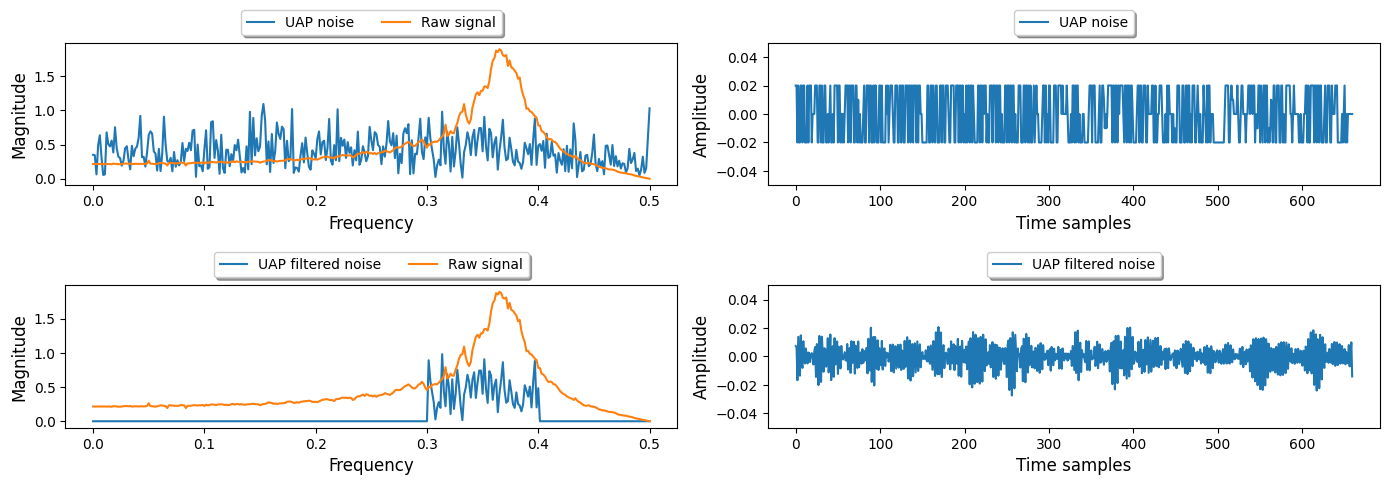

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 5), dpi=100, facecolor='w', edgecolor='k')

pass1 = torch.abs(fft.rfftfreq(adv_noise_uap.shape[-1])) < 0.4
pass2 = torch.abs(fft.rfftfreq(adv_noise_uap.shape[-1])) > 0.3
kernel = pass1 * pass2
fft_input = fft.rfft2(adv_noise_uap)
delta = fft.irfft2(fft_input * kernel, s=adv_noise_uap.shape[-2:])

i = 8
PGD_synch = torch.abs(fft.rfft(data[i][0]))
PGD_desynch =torch.abs(fft.rfft(adv_noise_uap[0][0])) 

FGSM_synch = torch.abs(fft.rfft(data[i][0]))
FGSM_desynch =torch.abs(fft.rfft(delta[0][0])) 
x = fft.rfftfreq(adv_noise_uap.shape[-1])

#------------------------------------

PGD_synch_ = data[i][0]
PGD_desynch_ = adv_noise_uap[0][0] 

FGSM_synch_ = data[i][0]
FGSM_desynch_ =delta[0][0] 
x_ = range(0,660)

#---------------------------------------
plt.subplot(2, 2, 1)

plt.plot(x,PGD_desynch,linewidth=1.5, label="UAP noise")  #SRP
plt.plot(x,PGD_synch,linewidth=1.5, label="Raw signal")

plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)

#plt.title('Frequency Spectrum')
L1 = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
          ncol=3, fancybox=True, shadow=True)
#----------------------------------------
plt.subplot(2, 2, 2)
plt.plot(x_,PGD_desynch_,linewidth=1.5, label="UAP noise")  #SRP

plt.xlabel('Time samples', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.ylim(bottom = -0.05,top=0.05)
#plt.title('Frequency Spectrum')
L2 = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
          ncol=3, fancybox=True, shadow=True)
#----------------------------------------
plt.subplot(2, 2, 3)
plt.plot(x,FGSM_desynch,linewidth=1.5, label="UAP filtered noise") #SRP
plt.plot(x,FGSM_synch,linewidth=1.5, label="Raw signal")

#plt.ylim(14,27.5)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)

#plt.title('Frequency Spectrum')
plt.tight_layout()
L3 =plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
          ncol=3, fancybox=True, shadow=True)
#----------------------------------------
plt.subplot(2, 2, 4)
plt.plot(x_,FGSM_desynch_,linewidth=1.5, label="UAP filtered noise") #SRP   color='indianred',
#plt.ylim(14,27.5)
plt.xlabel('Time samples', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.ylim(bottom = -0.05,top=0.05)
#plt.title('Frequency Spectrum')
plt.tight_layout()
L4 = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
          ncol=3, fancybox=True, shadow=True)
#----------------------------------------

#from google.colab import files
#plt.savefig("uap_filtered.pdf", bbox_extra_artists=(L1,L2,L3,L4,), bbox_inches='tight')
#files.download("uap_filtered.pdf") 
#plt.show()

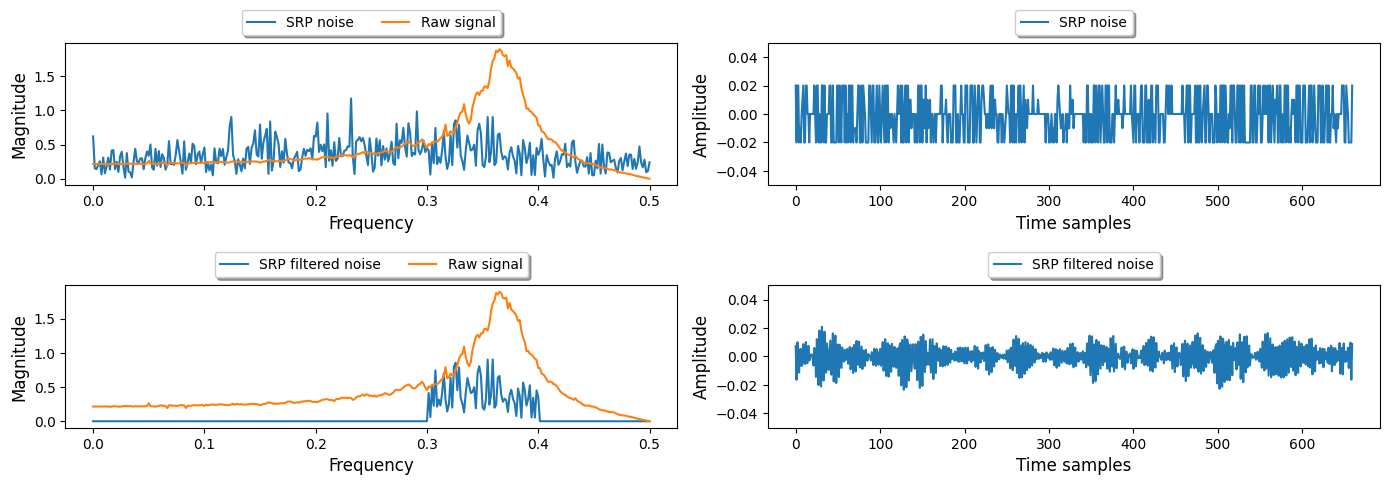

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 5), dpi=100, facecolor='w', edgecolor='k')

pass1 = torch.abs(fft.rfftfreq(adv_noise.shape[-1])) < 0.4
pass2 = torch.abs(fft.rfftfreq(adv_noise.shape[-1])) > 0.3
kernel = pass1 * pass2
fft_input = fft.rfft2(adv_noise)
delta = fft.irfft2(fft_input * kernel, s=adv_noise.shape[-2:])

i = 8
PGD_synch = torch.abs(fft.rfft(data[i][0]))
PGD_desynch =torch.abs(fft.rfft(adv_noise[0][0]))  #noise

FGSM_synch = torch.abs(fft.rfft(data[i][0]))
FGSM_desynch =torch.abs(fft.rfft(delta[0][0]))  #delta[0][0]
x = fft.rfftfreq(adv_noise.shape[-1])

#------------------------------------

PGD_synch_ = data[i][0]
PGD_desynch_ = adv_noise[0][0]  #noise[0][0]

FGSM_synch_ = data[i][0]
FGSM_desynch_ = delta[0][0]  #delta[0][0]
x_ = range(0,660)

#---------------------------------------
plt.subplot(2, 2, 1)
plt.plot(x,PGD_desynch, linewidth=1.5, label="SRP noise")  #SRP
plt.plot(x,PGD_synch, linewidth=1.5, label="Raw signal")


plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)

#plt.title('Frequency Spectrum')
L1 = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
          ncol=3, fancybox=True, shadow=True)
#----------------------------------------
plt.subplot(2, 2, 2)
plt.plot(x_,PGD_desynch_,linewidth=1.5, label="SRP noise")  #SRP

plt.xlabel('Time samples', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.ylim(bottom = -0.05,top=0.05)
#plt.title('Frequency Spectrum')
L2 = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
          ncol=3, fancybox=True, shadow=True)
#----------------------------------------
plt.subplot(2, 2, 3)
plt.plot(x,FGSM_desynch,linewidth=1.5, label="SRP filtered noise") #SRP
plt.plot(x,FGSM_synch,linewidth=1.5, label="Raw signal")

#plt.ylim(14,27.5)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)

#plt.title('Frequency Spectrum')
plt.tight_layout()
L3 =plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
          ncol=3, fancybox=True, shadow=True)
#----------------------------------------
plt.subplot(2, 2, 4)
plt.plot(x_,FGSM_desynch_,linewidth=1.5, label="SRP filtered noise") #SRP   color='indianred',
#plt.ylim(14,27.5)
plt.xlabel('Time samples', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.ylim(bottom = -0.05,top=0.05)
#plt.title('Frequency Spectrum')
plt.tight_layout()
L4 = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
          ncol=3, fancybox=True, shadow=True)
#----------------------------------------

#from google.colab import files
#plt.savefig("srp_filtered.pdf", bbox_extra_artists=(L1,L2,L3,L4,), bbox_inches='tight')
#files.download("srp_filtered.pdf") 
#plt.show()

* Impact of filtering on sota attack based patches

In [115]:
correct = 0
for data, target in test_dataloader:
    k = np.random.randint(0, maxlen) #-lengths
    adv_noise = torch.from_numpy(fill_before(k, adv_noise_uap.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()
    pass1 = torch.abs(fft.rfftfreq(adv_noise.shape[-1])) < 0.4
    pass2 = torch.abs(fft.rfftfreq(adv_noise.shape[-1])) > 0.3
    kernel = pass1* pass2
    fft_input = fft.rfft(adv_noise)
    adv_noise_fft = fft.irfft(fft_input * kernel)

    output = model(data + adv_noise_fft) 
    pred = output.argmax(dim=1, keepdim=True) 
    #print(pred) 
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nAdv Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_dataloader.dataset),
    100-100. * correct / len(test_dataloader.dataset)))


Adv Accuracy: 180/294 (39%)



#5. A-RNA

In [107]:
def a_rna(images, labels, max_iter, eps, num_steps, step_size, norm, eps_norm, step_norm, loss_fn, lengths, maxlen): 
    # Init universal perturbation
    x = images #
    y_index = np.argmax(labels, axis=1) #
    nb_instances = len(x)
    noise = torch.zeros((lengths)) 
    # Generate the adversarial examples
    nb_iter = 0
    threshold = 0.3

    while nb_iter < max_iter:
        # Go through all the examples randomly
        rnd_idx = random.sample(range(nb_instances), nb_instances)
        print(nb_iter)

        # Go through the data set and compute the perturbation increments sequentially
        for j, ex in enumerate(x[rnd_idx]):
            x_i = ex[None, ...]
            #select random position k
            k = np.random.randint(0, maxlen)  # -lengths

            current_label = model(x_i +  torch.from_numpy(fill_before(k, noise.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()).argmax(dim=1, keepdim=True)
            original_label = y_index[rnd_idx][j]

            if current_label == original_label:
                # Compute adversarial perturbation
                adv_xi = pgd(model, (x_i +   torch.from_numpy(fill_before(k, noise.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()), labels[rnd_idx][[j]],  
                            loss_fn =loss_fn, num_steps = num_steps, step_size = step_size, step_norm = step_norm, eps_norm = eps_norm, eps = torch.tensor(eps), y_target=None)

                new_label = model(adv_xi.float()).argmax(dim=1, keepdim=True) 

                # If the class has changed, update v
                if current_label != new_label:
                    if k != 0:
                        noise = torch.cat(((adv_xi.detach() - x_i.detach())[0,0,k:maxlen],(adv_xi.detach() - x_i.detach())[0,0,0:k] ), 0)
                    else:
                        noise = adv_xi.detach() - x_i.detach()
                    pass1 = torch.abs(fft.rfftfreq(noise.shape[-1])) < 0.4
                    pass2 = torch.abs(fft.rfftfreq(noise.shape[-1])) > 0.3
                    kernel = pass1* pass2
                    fft_input = fft.rfft(noise)
                    noise = fft.irfft(fft_input * kernel)
                    noise = projection(noise, eps, norm).float()

        nb_iter += 1
    return noise


In [111]:
test_dataloader = DataLoader(test_dataset, batch_size = 1)
for data, target in test_dataloader:
    data, target = data, target

correct = 0

max_iter = 20
eps = 0.04   
num_steps = 20 
step_size = 0.01  #0.01
norm = np.inf
lengths = 660 
maxlen = 660
eps_norm='inf' 
step_norm='inf'
loss_fn = nn.CrossEntropyLoss()

adv_noise_rna = a_rna(images, labels, max_iter, eps, num_steps, step_size, norm, eps_norm, step_norm, loss_fn, lengths, maxlen)

for data, target in test_dataloader:
    k = np.random.randint(0, maxlen)
    #adv_noise = torch.from_numpy(mask_applied_anywhere(noise.numpy(), lengths, maxlen, k)).float()
    adv_noise = torch.from_numpy(fill_before(k, adv_noise_rna.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()
    output = model(data + adv_noise) 
    pred = output.argmax(dim=1, keepdim=True) 
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nAdv Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_dataloader.dataset),
    100 - 100. * correct / len(test_dataloader.dataset)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19

Adv Accuracy: 52/294 (82%)



In [114]:
correct = 0
for data, target in test_dataloader:
    k = np.random.randint(0, maxlen) #-lengths
    adv_noise = torch.from_numpy(fill_before(k, adv_noise_rna.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()
    pass1 = torch.abs(fft.rfftfreq(adv_noise.shape[-1])) < 0.4
    pass2 = torch.abs(fft.rfftfreq(adv_noise.shape[-1])) > 0.3
    kernel = pass1* pass2
    fft_input = fft.rfft(adv_noise)
    adv_noise_fft = fft.irfft(fft_input * kernel)

    output = model(data + adv_noise_fft) 
    pred = output.argmax(dim=1, keepdim=True) 
    #print(pred) 
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nAdv Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_dataloader.dataset),
    100-100. * correct / len(test_dataloader.dataset)))


Adv Accuracy: 59/294 (80%)



In [112]:
from skimage.metrics import structural_similarity as ssim
print("SSIM = ", ssim(data.view(-1).numpy(), (data+adv_noise_rna).view(-1).numpy()))

SSIM =  0.786411412956653


#6. With Channel Information

In [147]:

def a_rna_w_channel( images, labels, max_iter, eps, num_steps, step_size, norm, eps_norm, step_norm, loss_fn, lengths, maxlen, k = 8, sigma = 0.25):
    # Init universal perturbation
    x = images #
    y_index = np.argmax(labels, axis=1) #
    nb_instances = len(x)

    #noise = torch.zeros((lengths)) #torch.zeros(1,1,lengths)
    noise_t = torch.rand((lengths))
    # Generate the adversarial examples
    nb_iter = 0
    threshold = 0.3
    #-------Channel model---------------
    b = np.sqrt(k*2*sigma*sigma)
    #-----------------------------

    while nb_iter < max_iter:
        # Go through all the examples randomly
        rnd_idx = random.sample(range(nb_instances), nb_instances)
        print(nb_iter)

        # Go through the data set and compute the perturbation increments sequentially
        for j, ex in enumerate(x[rnd_idx]):
            x_i = ex[None, ...]
            #select random position k
            k = np.random.randint(0, maxlen)  # -lengths

            
            #--------------------noise----------------------------
            h = rice(b, loc=0, scale=sigma).rvs(size=660)
            h_rice = np.expand_dims(h, axis=0)
            noise = torch.from_numpy(h_rice)*noise_t
            noise = projection(noise, eps, norm).float()
            #-----------------------------------
            epsilon = torch.tensor(eps)
            current_label = model(x_i +  torch.from_numpy(fill_before(k, noise.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()).argmax(dim=1, keepdim=True)
            original_label = y_index[rnd_idx][j]

            if current_label == original_label:
                # Compute adversarial perturbation
                #adv_xi = fgsm(model, (x_i +  torch.from_numpy(mask_applied_anywhere(noise.numpy(), lengths, maxlen, k)).float()),labels[rnd_idx][[j]] , lengths, maxlen, k, eps)  # torch.from_numpy(np.array([[0., 0., 0., 0., 1.]]))
                adv_xi = pgd(model, (x_i +   torch.from_numpy(fill_before(k, noise.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()), labels[rnd_idx][[j]], 
                              loss_fn =loss_fn, num_steps = num_steps, step_size = step_size, step_norm = step_norm, eps_norm = eps_norm, eps = epsilon, y_target=None)

                new_label = model(adv_xi.float()).argmax(dim=1, keepdim=True) 
                
                # If the class has changed, update v
                if current_label != new_label:

                    if k != 0:
                        noise = torch.cat(((adv_xi.detach() - x_i.detach())[0,0,k:maxlen],(adv_xi.detach() - x_i.detach())[0,0,0:k] ), 0)
                    else:
                        noise = adv_xi.detach() - x_i.detach()
                    #-------Filter------------------    
                    h = rice(b, loc=0, scale=sigma).rvs(size=660)
                    h_rice = np.expand_dims(h, axis=0)
                    noise_t = noise*(1/torch.from_numpy(h_rice))

                    pass1 = torch.abs(fft.rfftfreq(noise_t.shape[-1])) < 0.4
                    pass2 = torch.abs(fft.rfftfreq(noise_t.shape[-1])) > 0.3
                    kernel = pass1* pass2
                    fft_input = fft.rfft(noise_t)
                    noise_t = fft.irfft(fft_input * kernel)
                    #-------Projection------------------ 
                    noise_t = projection(noise_t, torch.tensor(0.1), norm).float()  #eps/(h_rice.min()*10)


        nb_iter += 1
    return noise_t


In [155]:
test_dataloader = DataLoader(test_dataset, batch_size = 1)
for data, target in test_dataloader:
    data, target = data, target
correct = 0

max_iter = 10
eps = 0.02   
num_steps = 20 
step_size = 0.01
norm = np.inf
lengths = 660  
maxlen = 660
k = 8
sigma = 0.25
eps_norm='inf' 
step_norm='inf'
loss_fn = nn.CrossEntropyLoss()

adv_noise_rna_channel = a_rna_w_channel(images, labels, max_iter, eps, num_steps, step_size, norm, eps_norm, step_norm, loss_fn, lengths, maxlen, k, sigma)

for data, target in test_dataloader:
    
    b = np.sqrt(k*2*sigma*sigma)
    k = np.random.randint(0, maxlen)
    h = rice(b, loc=0, scale=sigma).rvs(size=660)
    h_rice = np.expand_dims(h, axis=0)
    noise = torch.from_numpy(h_rice)*adv_noise_rna_channel

    adv_noise = torch.from_numpy(fill_before(k, noise.view(-1).numpy(), lengths, maxlen)).reshape(1,1,660).float()
    output = model(data+ torch.from_numpy(h_rice).reshape(1,1,660).float()*adv_noise ) 
    pred = output.argmax(dim=1, keepdim=True) 

    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nAdv Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_dataloader.dataset),
    100 - 100. * correct / len(test_dataloader.dataset)))

0
1
2
3
4
5
6
7
8
9

Adv Accuracy: 52/294 (82%)



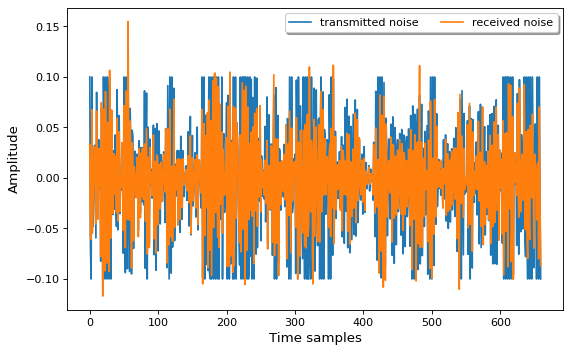

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')

h = rice(b, loc=0, scale=sigma).rvs(size=660)
h_rice = np.expand_dims(h, axis=0)
noise = torch.from_numpy(h_rice)*adv_noise_rna_channel

x = range(0,660)
plt.plot(x,adv_noise_rna_channel.view(-1),linewidth=1.5, label="transmitted noise")
plt.plot(x,noise.view(-1),linewidth=1.5, label="received noise") 
#plt.plot(x,data.view(-1),linewidth=1.5, label="received signal")
plt.xlabel('Time samples', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
#plt.ylim(bottom = -0.4,top=0.4)
#plt.title('Frequency Spectrum')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1),
          ncol=3, fancybox=True, shadow=True)
plt.show()
#plt.style.use('ggplot')    #ggplot

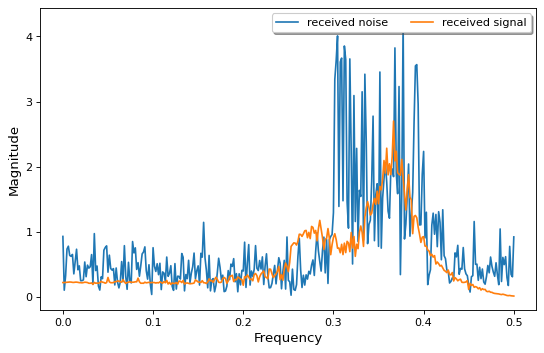

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')

#PGD_synch = data[14][0]
#PGD_desynch = noise
h = rice(b, loc=0, scale=sigma).rvs(size=660)
h_rice = np.expand_dims(h, axis=0)
noise = torch.from_numpy(h_rice)*adv_noise_rna_channel
x = fft.rfftfreq(noise.shape[-1])
#plt.plot(x,noise_t.view(-1),color='royalblue',linewidth=1.5, label="transmitted noise")
plt.plot(x, torch.abs(fft.rfft(noise.view(-1))) ,linewidth=1.5, label="received noise") 
plt.plot(x, torch.abs(fft.rfft(data.view(-1))) ,linewidth=1.5, label="received signal") 
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
#plt.ylim(bottom = -0.4,top=0.4)
#plt.title('Frequency Spectrum')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1),
          ncol=3, fancybox=True, shadow=True)
plt.show()
#plt.style.use('ggplot')    #ggplot

* Rician channel

In [125]:
from scipy.stats import rice
def rician_channel(x, A, sigma):
    scale = sigma
    b = A #/scale
    #h = rice.rvs( b, scale, size = x.size())
    h = rice(b, loc=0, scale=sigma).rvs(size=660)
    return h

In [126]:
A = 1 
sigma= 0.25
h_rice = rician_channel( x = noise, A =A, sigma=sigma)
h_ar = np.expand_dims(h_rice, axis=-1)

In [127]:
h_rice = rician_channel( x = noise, A =A, sigma=sigma)
h_ar = np.expand_dims(h_rice, axis=-1)

In [142]:
A = 1 
sigma= 0.25
h_rice = rician_channel( x = adv_noise_rna, A =A, sigma=sigma)
print("k =", (A*A)/(2*sigma*sigma))
h_ar = np.expand_dims(h_rice, axis=-1)
noise_r_ = np.expand_dims(adv_noise_rna, axis=-1)
noise_t = noise_r_*(1/h_ar)
h_rice = rician_channel( x = adv_noise_rna, A =A, sigma=sigma)
print("k =", (A*A)/(2*sigma*sigma))
h_ar = np.expand_dims(h_rice, axis=-1)
noise_rr = h_ar*noise_t


k = 8.0
k = 8.0


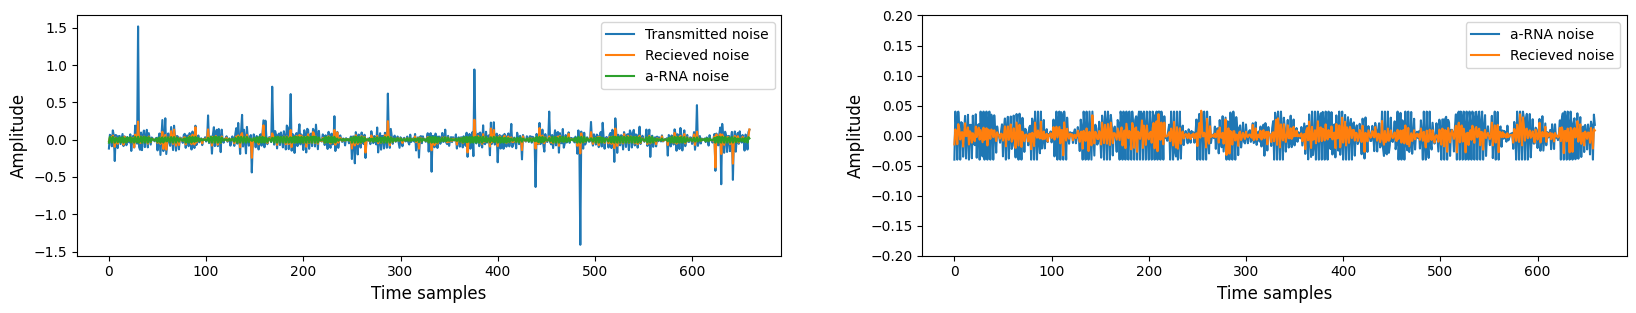

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 7), dpi=100, facecolor='w', edgecolor='k')


#------------------------------------
n1 = noise_t
n2 = noise_rr
n3 = noise_r_

#---------------------------------------
plt.subplot(2, 2, 1)

plt.plot(n1, label='Transmitted noise')
plt.plot(n2, label='Recieved noise')
plt.plot(n3, label='a-RNA noise')

plt.xlabel('Time samples', fontsize = 12)
plt.ylabel('Amplitude', fontsize = 12)
plt.legend()

#plt.title('Frequency Spectrum')
#L1 = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
#          ncol=3, fancybox=True, shadow=True)
#----------------------------------------
plt.subplot(2, 2, 2)
plt.plot(adv_noise_rna, label='a-RNA noise')
plt.plot(noise_r, label='Recieved noise')
plt.ylim(bottom = -0.2,top=0.2)
plt.ylim(bottom = -0.2,top=0.2)
#plt.plot(noise_r, label='a-RNA noise')

plt.xlabel('Time samples', fontsize = 12)
plt.ylabel('Amplitude', fontsize = 12)
plt.legend()
#plt.ylim(bottom = -0.05,top=0.05)
#plt.title('Frequency Spectrum')
#L2 = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
#          ncol=3, fancybox=True, shadow=True)
#----------------------------------------


* Rayleigh channel

In [130]:
def channel_ar_rayleigh(lengths, d, K = 1, d0 = 1, gamma = 2):
  h_ar = np.zeros(lengths)
  #for i in range(lengths):
  psi =  np.random.lognormal(mean=0.0, sigma=1.6, size=(lengths)) #Lognormal(0,8)  [shadowing]
  ray =  np.random.rayleigh(scale=0.5, size=(lengths)) #Rayleigh(0,1)
  h_ar = ray #np.power(K*(d0/d), gamma)*psi*ray
  return h_ar

In [138]:
h_ar = channel_ar_rayleigh(lengths = 660, d = 5, K = 1, d0 = 1, gamma = 2.7)
noise_r = np.expand_dims(adv_noise_rna, axis=-1)
h_ar = np.expand_dims(h_ar, axis=-1)
noise_t = noise_r*(1/h_ar)
h_ar = channel_ar_rayleigh(lengths = 660, d = 5, K = 1, d0 = 1, gamma = 2.7)
h_ar = np.expand_dims(h_rice, axis=-1)
noise_rr = h_ar*noise_t

In [139]:
h_ar = channel_ar_rayleigh(lengths = 660, d = 5, K = 1, d0 = 1, gamma = 2.7)
h_ar = np.expand_dims(h_rice, axis=-1)
noise_ = np.expand_dims(adv_noise_rna.numpy(), axis=-1)
noise_r = h_ar*noise_ #t

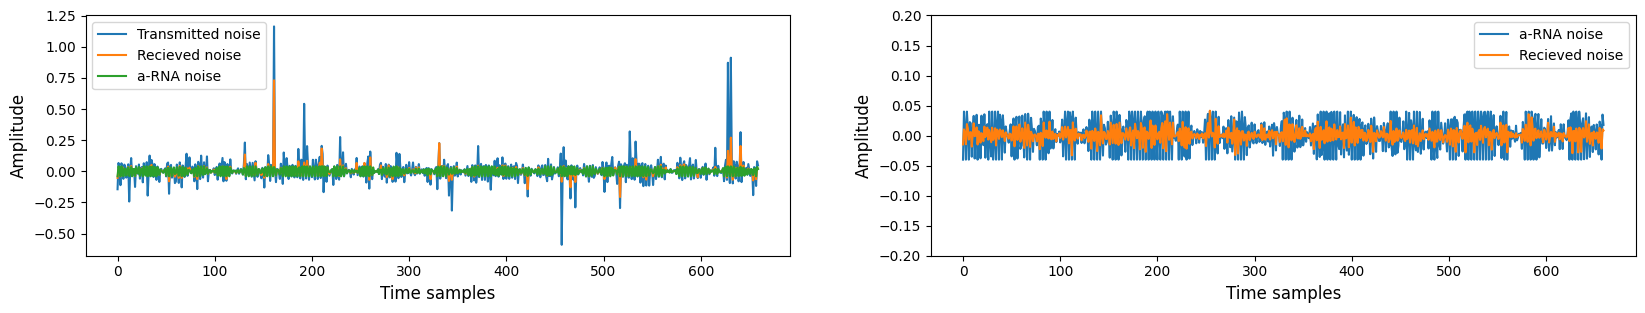

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 7), dpi=100, facecolor='w', edgecolor='k')


#------------------------------------
n1 = noise_t
n2 = noise_rr
n3 = noise_r_

#---------------------------------------
plt.subplot(2, 2, 1)

plt.plot(n1, label='Transmitted noise')
plt.plot(n2, label='Recieved noise')
plt.plot(n3, label='a-RNA noise')

plt.xlabel('Time samples', fontsize = 12)
plt.ylabel('Amplitude', fontsize = 12)
plt.legend()

#plt.title('Frequency Spectrum')
#L1 = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
#          ncol=3, fancybox=True, shadow=True)
#----------------------------------------
plt.subplot(2, 2, 2)
plt.plot(adv_noise_rna, label='a-RNA noise')
plt.plot(noise_r, label='Recieved noise')
plt.ylim(bottom = -0.2,top=0.2)
plt.ylim(bottom = -0.2,top=0.2)
#plt.plot(noise_r, label='a-RNA noise')

plt.xlabel('Time samples', fontsize = 12)
plt.ylabel('Amplitude', fontsize = 12)
plt.legend()
#plt.ylim(bottom = -0.05,top=0.05)
#plt.title('Frequency Spectrum')
#L2 = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.28),
#          ncol=3, fancybox=True, shadow=True)
#----------------------------------------


# 7. Patches under time visibility constraints

In [51]:
def a_rna_w_time_constraint(images, labels, max_iter, eps, num_steps, step_size, norm, eps_norm, step_norm, loss_fn, lengths, maxlen):
    # Init universal perturbation
    x = images #
    y_index = np.argmax(labels, axis=1) #

    nb_instances = len(x)
    noise = torch.zeros(lengths)

    # Generate the adversarial examples
    nb_iter = 0

    while nb_iter < max_iter:
        # Go through all the examples randomly
        rnd_idx = random.sample(range(nb_instances), nb_instances)
        print(nb_iter)

        # Go through the data set and compute the perturbation increments sequentially
        for j, ex in enumerate(x[rnd_idx]):
            x_i = ex[None, ...]
            #select random position k
            k = np.random.randint(0, maxlen-lengths) #-lengths

            #current_label = model(x_i + noise).argmax(dim=1, keepdim=True)
            #noise = torch.from_numpy(mask_applied_anywhere(noise.numpy(), lengths, maxlen, k))
            current_label = model(x_i + torch.from_numpy(mask(noise.numpy(), lengths, maxlen, k))).argmax(dim=1, keepdim=True)

            original_label = y_index[rnd_idx][j]

            if current_label == original_label:
                # Compute adversarial perturbation
                adv_xi = pgd(model, (x_i +   torch.from_numpy(mask(noise.numpy(), lengths, maxlen, k))), labels[rnd_idx][[j]],  
                            loss_fn =loss_fn, num_steps = num_steps, step_size = step_size, step_norm = step_norm, eps_norm = eps_norm, eps = torch.tensor(eps), y_target=None)
                new_label = model(adv_xi.float()).argmax(dim=1, keepdim=True) 

                # If the class has changed, update v
                if current_label != new_label:
                    noise = (adv_xi.detach() - x_i.detach())[0,0,k:k+lengths]
                    noise = projection(noise, eps, norm).float()
                    #print(noise.shape)
                

        nb_iter += 1
    return noise


In [110]:
test_dataloader = DataLoader(test_dataset, batch_size = 1)
for data, target in test_dataloader:
    data, target = data, target

correct = 0

max_iter = 20
eps = 0.04   
num_steps = 20 
step_size = 0.01  #0.01
norm = np.inf
lengths = 200 #size of the patch
maxlen = 660
eps_norm='inf' 
step_norm='inf'
loss_fn = nn.CrossEntropyLoss()

adv_noise_seq = a_rna_w_time_constraint(images, labels, max_iter, eps, num_steps, step_size, norm, eps_norm, step_norm, loss_fn, lengths, maxlen)

for data, target in test_dataloader:
    k = np.random.randint(0, maxlen-lengths) #
    adv_noise = torch.from_numpy(mask(adv_noise_seq.numpy(), lengths, maxlen, k))
    output = model(data + adv_noise) 
    pred = output.argmax(dim=1, keepdim=True) 
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nAdv Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_dataloader.dataset),
    100 - 100. * correct / len(test_dataloader.dataset)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19

Adv Accuracy: 142/294 (52%)



In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = 1)
for data, target in test_dataloader:
    data, target = data, target


max_iter = 20
eps = 0.03   
num_steps = 20 
step_size = 0.01  #0.01
norm = np.inf
lengths = np.array([50,100,200,300,400,500,600]) #size of the patch
maxlen = 660
eps_norm='inf' 
step_norm='inf'
loss_fn = nn.CrossEntropyLoss()
acc_seq = np.zeros_like(lengths)
for i in range(len(lengths)):
    adv_noise_seq = a_rna_w_time_constraint(images, labels, max_iter, eps, num_steps, step_size, norm, eps_norm, step_norm, loss_fn, lengths[i], maxlen)
    correct = 0
    for data, target in test_dataloader:
        k = np.random.randint(0, maxlen-lengths[i]) #
        adv_noise = torch.from_numpy(mask(adv_noise_seq.numpy(), lengths[i], maxlen, k))
        output = model(data + adv_noise) 
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()

    acc_seq[i] = 100 - 100. * correct / len(test_dataloader.dataset)



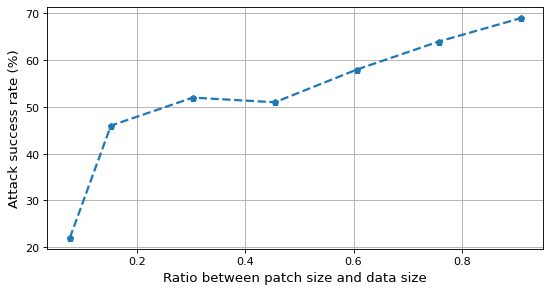

In [119]:
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

plt.plot(lengths/660, acc_seq, 'p--',linewidth=2) 
plt.xlabel('Ratio between patch size and data size', fontsize = 12)
plt.ylabel('Attack success rate (%)', fontsize = 12)
plt.grid(True)